Useful msprime docs:
https://github.com/jeromekelleher/spg-chapter/blob/master/jupyter/msprime-chapter-examples.ipynb

In [181]:
%matplotlib inline
from __future__ import print_function
import msprime
import matplotlib.pyplot as plt
import ipyrad.analysis as ipa
import numpy as np
import pandas as pd
import ipyparallel as ipp
import datetime
import time
import sys
import os
from tempfile import TemporaryFile
from IPython.display import SVG, display

simout = "simout"

In [178]:
def progressbar(njobs, finished, msg="", spacer="  "):
    """ prints a progress bar """
    if njobs:
        progress = 100*(finished / float(njobs))
    else:
        progress = 100

    hashes = '#'*int(progress/5.)
    nohash = ' '*int(20-len(hashes))

    args = [spacer, hashes+nohash, int(progress), msg]
    print("\r{}[{}] {:>3}% {} ".format(*args), end="")
    sys.stdout.flush()

for i in range(100):
    progressbar(100, i, "watdo")
progressbar(100, 100, "done")

  [####################] 100% done  

  INFO: # PCs < # samples. Forcing # PCs = 8


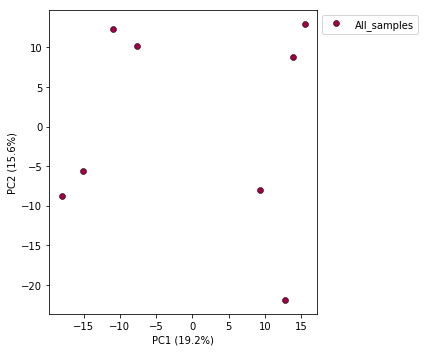

In [185]:
local_Ne = 1e5
g = 0
split_time = 2e5
pop1_samples = 8
pop2_samples = 8
nloci = 1000
length=150

migmat = [[0, 0], [0, 0]]

def simulate_nloci(n=1, split_time=2e5, pop1_samples=8, pop2_samples=8, nloci=100, migmat=[[0, 0], [0, 0]]):
    ts_list = []
    for i in xrange(n):
        pop1 = msprime.PopulationConfiguration(sample_size=pop1_samples,
                                            initial_size=local_Ne,
                                            growth_rate=g)

        pop2 = msprime.PopulationConfiguration(sample_size=pop2_samples,
                                            initial_size=local_Ne,
                                            growth_rate=g)

        split_event = msprime.MassMigration(time=split_time,
                                            source=0,
                                            destination=1,
                                            proportion=1)

        debug = msprime.DemographyDebugger(population_configurations=[pop1, pop2],
                                            demographic_events=[split_event],
                                            migration_matrix=migmat)

        tree_sequence = msprime.simulate(length=length,\
                                            migration_matrix=migmat,\
                                            mutation_rate=1e-8, \
                                            population_configurations=[pop1, pop2],\
                                            demographic_events=[split_event])
        ts_list.append(tree_sequence)

    return ts_list

def plot_tree_sequence(tree_sequence):
    tree = tree_sequence.first()
    colour_map = {0:"red", 1:"blue"}
    node_colours = {u: colour_map[tree.population(u)] for u in tree.nodes()}
    display(SVG(tree.draw(width=600, height=400, node_colours=node_colours)))

def write_vcf(ts_list, outfile, unlinked=False):
    with open(outfile, 'w') as output:
        ts_list[0].write_vcf(output, ploidy=2, contig_id='1')
        for i, ts in enumerate(ts_list[1:]):
            with TemporaryFile() as outtmp:
                ## the +2 here is because enumerate starts at 0, and we
                ## want our first locus of this list to start at 2
                ts.write_vcf(outtmp, ploidy=2, contig_id=str(i+2))
                outtmp.seek(0)
                ## Get rid of the 6 lines of vcf header
                dat = outtmp.readlines()[6:]
                if unlinked:
                    try:
                        dat = np.random.choice(dat, size=1)
                    except:
                        ## ignore loci with no snps
                        pass
                output.write("".join(dat))

def simulate_missing(infile, outfile=None, avg_missing=0.3, std_missing=0.05):
    if outfile == None:
        outfile = infile
    dat = ''
    header = ''
    with open(infile) as infile:
        dat = infile.readlines()
        header = dat[:6]
        dat = pd.DataFrame([x.split() for x in dat[6:]], columns=header[-1].split())
        samps = [x for x in dat.columns if "msp" in x]
        missingness = np.random.normal(avg_missing, std_missing, len(samps))
        for samp, miss in zip(samps, missingness):
            #print(samp, miss, len(dat[samp]))
            draws = np.random.uniform(size=len(dat[samp]))
            dat[samp] = np.where(draws < miss, ".|.", dat[samp])
    with open(outfile, 'w') as outfile:
        outfile.write("".join(header))
        dat.to_csv(outfile, sep="\t", index=False, header=False)

## 100 loci is almost instant
## 1000 loci ~5 seconds
migmat = [[0, 1e-5], [1e-5, 0]]
ts_list = simulate_nloci(n=nloci, migmat=migmat)
#plot_tree_sequence(ts_list[0])
write_vcf(ts_list, "./{}/tmp.vcf".format(simout), unlinked=True)
simulate_missing("{}/tmp.vcf".format(simout), avg_missing=0.5)
pca = ipa.pca("./{}/tmp.vcf".format(simout))
pca.plot()

## Simulate vcf files serially

In [230]:
nsims = 5
models = {"no_migration":[[0, 0], [0, 0]],
          "symmetric_migration":[[0, 1e-5], [1e-5, 0]],
          "asymmetric_migration":[[0, 1e-5], [1e-6, 0]]}

for model, migmat in models.items():
    outdir = "./{}/{}".format(simout, model)
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    for i in xrange(nsims):
        print("Doing {} {}".format(model, i))
        ts_list = simulate_nloci(nloci, migmat=migmat)
        write_vcf(ts_list, "./{}/{}-sim{}.vcf".format(outdir, model, i), unlinked=False)
        simulate_missing("{}/{}-sim{}.vcf".format(outdir, model, i))


Doing no_migration 0
Doing no_migration 1
Doing no_migration 2
Doing no_migration 3
Doing no_migration 4
Doing symmetric_migration 0
Doing symmetric_migration 1
Doing symmetric_migration 2
Doing symmetric_migration 3
Doing symmetric_migration 4
Doing asymmetric_migration 0
Doing asymmetric_migration 1
Doing asymmetric_migration 2
Doing asymmetric_migration 3
Doing asymmetric_migration 4


## Simulate vcf files in parallel
Broken

In [192]:
## Define a function so we can parallelize the above cell
def sim_vcf(model, nloci, missingness, migmat, outdir, rep):
    ts_list = simulate_nloci(nloci, migmat=migmat)
    write_vcf(ts_list, "./{}/{}-sim{}.vcf".format(outdir, model, rep), unlinked=False)
    simulate_missing("{}/{}-sim{}.vcf".format(outdir, model, rep), avg_missing=missingness)


In [242]:
## Run this in a python2.7 env and wait for clients to attach
#!ipcluster start -n 4 --cluster-id=ipp2 --daemonize
ipyclient = ipp.Client(cluster_id="ipp2")
print(len(ipyclient.ids))

5


In [244]:
nsims = 5
nloci = 1000
missingness = .3
models = {"no_migration":[[0, 0], [0, 0]],
          "symmetric_migration":[[0, 1e-5], [1e-5, 0]],
          "asymmetric_migration":[[0, 1e-5], [1e-6, 0]]}

ipyclient[:].use_dill()
ipyclient[:].push(dict(simulate_nloci=simulate_nloci, write_vcf=write_vcf, simulate_missing=simulate_missing))
lbview = ipyclient.load_balanced_view()
parallel_jobs = {}

start = time.time()
printstr = " Simulating vcf files  |  {}"
for model, migmat in models.items():
    outdir = "./{}/{}".format(simout, model)
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    for rep in xrange(nsims):
        parallel_jobs[rep] = lbview.apply(sim_vcf, *(model, nloci, missingness, migmat, outdir, rep))
    while 1:
        fin = [i.ready() for i in parallel_jobs.values()]
        elapsed = datetime.timedelta(seconds=int(time.time()-start))
        progressbar(len(fin), sum(fin),
                    printstr.format(elapsed))
        time.sleep(0.1)
        if len(fin) == sum(fin):
            print("")
            break

  [####################] 100%  Simulating vcf files  |  0:00:01 
  [####################] 100%  Simulating vcf files  |  0:00:01 
  [####################] 100%  Simulating vcf files  |  0:00:01 


In [250]:
#parallel_jobs[2].result()
ipyclient[0].push(dict(simulate_nloci=simulate_nloci, write_vcf=write_vcf, simulate_missing=simulate_missing))
wat = ipyclient[0].apply(sim_vcf, *(model, nloci, .3, migmat, "/tmp/", 0))
print(wat.result())

RemoteError: NameError(global name 'simulate_nloci' is not defined)

## Crap below here

In [62]:
avg_missing = 0.3
std_missing = 0.05

missingness = np.random.normal(avg_missing, std_missing, 8)
print(missingness)
draw = np.random.uniform(size=8)
print(draw)
ts = ts_list[1]
with TemporaryFile() as outtmp:
    ts.write_vcf(outtmp, ploidy=2, contig_id=str(i+2))
    outtmp.seek(0)
    ## Get rid of the 6 lines of vcf header
    dat = outtmp.readlines()[6:]
    print(dat[0])

[0.3044425  0.29402902 0.2848071  0.28072836 0.32856761 0.2867087
 0.28905754 0.28444419]
[0.13055066 0.27542815 0.31284536 0.08255794 0.0181362  0.28084621
 0.25152279 0.01150193]
6	60	.	A	T	.	PASS	.	GT	1|0	0|0	0|0	1|0	0|0	0|0	0|0	0|0



In [251]:

ts_list = simulate_nloci(100)
write_vcf(ts_list, "./100loci.vcf", unlinked=True)